In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import sys
from pyspark.sql import SparkSession
import gzip

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
spark = SparkSession.builder \
    .appName("MyApp") \
    .getOrCreate()

sc = spark.sparkContext

In [3]:
import glob

raw_data_file = 'access_log_JulAug_95'

print(raw_data_file)

access_log_JulAug_95


In [4]:
base_df = spark.read.text("access_log_JulAug_95")
base_df.printSchema()

root
 |-- value: string (nullable = true)


In [5]:
base_df_rdd = base_df.rdd
type(base_df_rdd)

pyspark.rdd.RDD

In [6]:
sample_logs = [item['value'] for item in base_df.take(15)]

In [7]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
hosts = [re.search(host_pattern, item).group(1)
           if re.search(host_pattern, item)
           else 'no match'
           for item in sample_logs]


In [8]:
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
timestamps = [re.search(ts_pattern, item).group(1) for item in sample_logs]

In [9]:
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
method_uri_protocol = [re.search(method_uri_protocol_pattern, item).groups()
               if re.search(method_uri_protocol_pattern, item)
               else 'no match'
              for item in sample_logs]

In [10]:
status_pattern = r'\s(\d{3})\s'
status = [re.search(status_pattern, item).group(1) for item in sample_logs]

In [11]:
content_size_pattern = r'\s(\d+)$'
content_size = [re.search(content_size_pattern, item).group(1) for item in sample_logs]

In [12]:
from pyspark.sql.functions import regexp_extract

logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|        199.72.81.55|01/Jul/1995:00:00...|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|
|unicomp6.unicomp.net|01/Jul/1995:00:00...|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   200|    

In [13]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum
def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)
# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|       33904|
+----+---------+------+--------+--------+------+------------+


In [14]:
logs_df = logs_df.na.fill({'content_size':0})
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+


In [15]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20]))

In [16]:
sample_ts = [item['timestamp'] for item in logs_df.select('timestamp').take(5)]
sample_ts

['01/Jul/1995:00:00:01 -0400',
 '01/Jul/1995:00:00:06 -0400',
 '01/Jul/1995:00:00:09 -0400',
 '01/Jul/1995:00:00:11 -0400',
 '01/Jul/1995:00:00:11 -0400']

In [17]:
[parse_clf_time(item) for item in sample_ts]

['1995-07-01 00:00:01',
 '1995-07-01 00:00:06',
 '1995-07-01 00:00:09',
 '1995-07-01 00:00:11',
 '1995-07-01 00:00:11']

In [18]:
udf_parse_time = udf(parse_clf_time)

logs_df = logs_df.select('*', udf_parse_time(logs_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
logs_df.show(10, truncate=True)

+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|        199.72.81.55|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|1995-07-01 00:00:01|
|unicomp6.unicomp.net|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|1995-07-01 00:00:06|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|1995-07-01 00:00:09|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|1995-07-01 00:00:11|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|1995-07-01 00:00:11|
|  burger.letters.com|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|1995-07-01 00:00:12|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   200|           0|1995-07-01 00:00:12|


In [19]:
logs_df.cache()

DataFrame[host: string, method: string, endpoint: string, protocol: string, status: int, content_size: int, time: timestamp]

### Part 1

C:\Users\duong\AppData\Local\Temp\ipykernel_11508\2702949145.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_hosts_data['weekday'] = pd.Categorical(top_5_hosts_data['weekday'], categories=weekday_order, ordered=True)


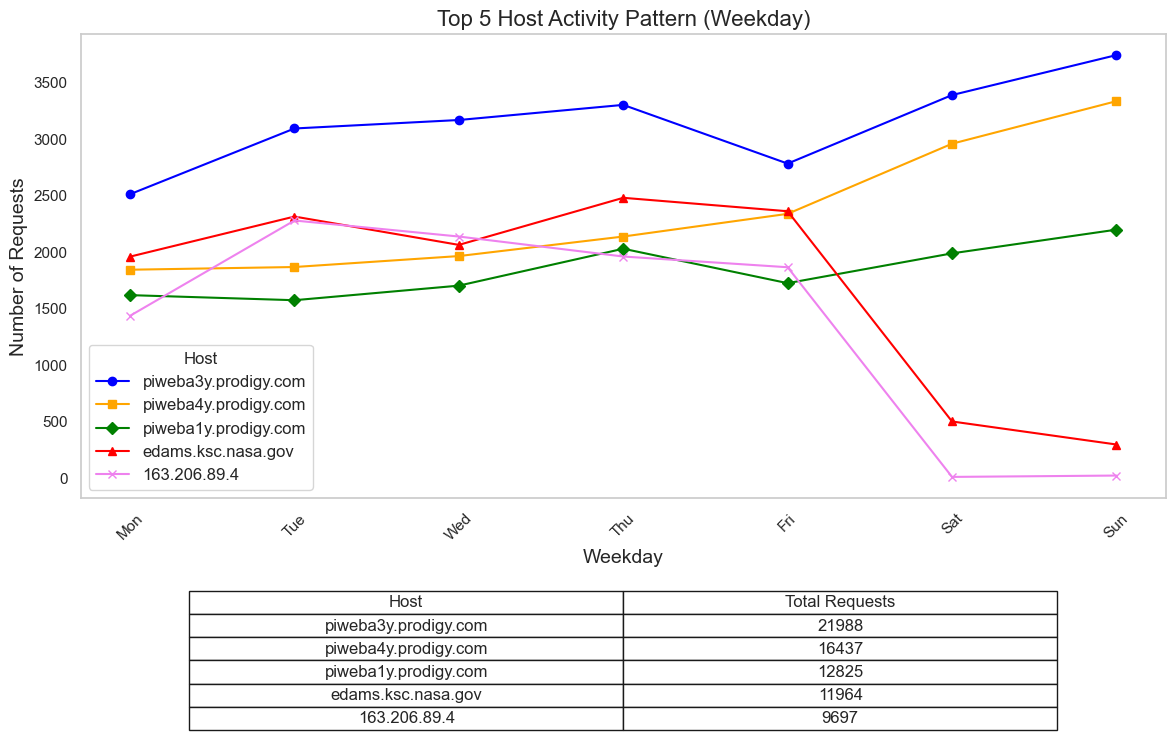

In [37]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd

# Add a 'weekday' column to the DataFrame
logs_df = logs_df.withColumn('weekday', F.date_format('time', 'E'))  # 'E' gives abbreviated day name

# Group by 'weekday' and 'host' to count requests
host_activity_weekday = logs_df.groupBy('weekday', 'host').count()

# Get the top 5 hosts based on total activity during weekdays
top_hosts = host_activity_weekday.groupBy('host').agg(F.sum('count').alias('total_requests')) \
                                   .orderBy('total_requests', ascending=False) \
                                   .limit(5)

# Get the top 5 hosts for plotting
top_5_hosts = top_hosts.limit(5).toPandas()

# Prepare data for plotting
host_activity_weekday_pd = host_activity_weekday.toPandas()
top_5_hosts_data = host_activity_weekday_pd[host_activity_weekday_pd['host'].isin(top_5_hosts['host'])]

# Define the custom order for weekdays
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Convert 'weekday' to a categorical type with the defined order
top_5_hosts_data['weekday'] = pd.Categorical(top_5_hosts_data['weekday'], categories=weekday_order, ordered=True)

# Sort the data by weekday
top_5_hosts_data = top_5_hosts_data.sort_values('weekday')

# Step 2: Plot the Data

# Create the figure and axis
plt.figure(figsize=(14, 8))

# Define colors and markers for different hosts
colors = ['blue', 'orange', 'green', 'red', 'violet']
markers = ['o', 's', 'D', '^', 'x']  # Circle, Square, Diamond, Triangle, X

# Plot each host's activity over weekdays
for i, host in enumerate(top_5_hosts['host']):
    host_data = top_5_hosts_data[top_5_hosts_data['host'] == host]
    plt.plot(host_data['weekday'], host_data['count'], label=host, color=colors[i], marker=markers[i])

# Add titles and labels
plt.title("Top 5 Host Activity Pattern (Weekday)", fontsize=16)
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Number of Requests", fontsize=14)
plt.legend(title="Host", fontsize=12)
plt.xticks(rotation=45)
plt.grid()

# Create a table below the plot for the top 5 hosts
top_5_hosts_pd = top_hosts.toPandas()
table_data = [
    ['Host', 'Total Requests'],
] + top_5_hosts_pd.values.tolist()

# Create a table
table = plt.table(cellText=table_data, colLabels=None, cellLoc='center', loc='bottom', bbox=[0.1, -0.5, 0.8, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Adjust layout to make room for the table
plt.subplots_adjust(bottom=0.3)

# Show the plot
plt.show()

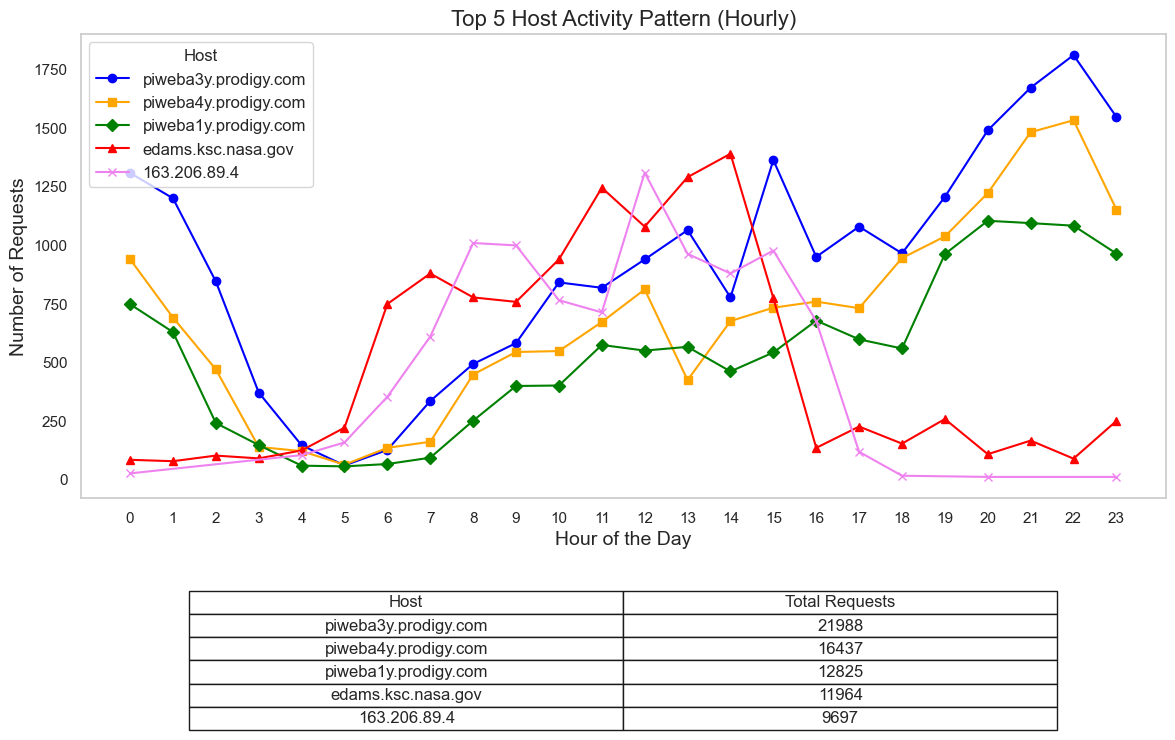

In [44]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd

# Add an 'hour' column to the DataFrame
logs_df = logs_df.withColumn('hour', F.hour('time'))  # Extract hour from the timestamp

# Group by 'hour' and 'host' to count requests
host_activity_hour = logs_df.groupBy('hour', 'host').count()

# Get the top 5 hosts based on total activity during hours
top_hosts = host_activity_hour.groupBy('host').agg(F.sum('count').alias('total_requests')) \
                               .orderBy('total_requests', ascending=False) \
                               .limit(5)

# Get the top 5 hosts for plotting
top_5_hosts = top_hosts.limit(5).toPandas()

# Prepare data for plotting
host_activity_hour_pd = host_activity_hour.toPandas()
top_5_hosts_data = host_activity_hour_pd[host_activity_hour_pd['host'].isin(top_5_hosts['host'])]

# Sort the data by hour
top_5_hosts_data = top_5_hosts_data.sort_values('hour')

# Step 2: Plot the Data

# Create the figure and axis
plt.figure(figsize=(14, 8))

# Define colors and markers for different hosts
colors = ['blue', 'orange', 'green', 'red', 'violet']
markers = ['o', 's', 'D', '^', 'x']  # Circle, Square, Diamond, Triangle, X

# Plot each host's activity over hours
for i, host in enumerate(top_5_hosts['host']):
    host_data = top_5_hosts_data[top_5_hosts_data['host'] == host]
    plt.plot(host_data['hour'], host_data['count'], label=host, color=colors[i], marker=markers[i])

# Add titles and labels
plt.title("Top 5 Host Activity Pattern (Hourly)", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Number of Requests", fontsize=14)
plt.legend(title="Host", fontsize=12)
plt.xticks(range(24))  # Set x-ticks to show all hours
plt.grid()

# Create a table below the plot for the top 5 hosts
top_5_hosts_pd = top_hosts.toPandas()
table_data = [
    ['Host', 'Total Requests'],
] + top_5_hosts_pd.values.tolist()

# Create a table
table = plt.table(cellText=table_data, colLabels=None, cellLoc='center', loc='bottom', bbox=[0.1, -0.5, 0.8, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Adjust layout to make room for the table
plt.subplots_adjust(bottom=0.3)

# Show the plot
plt.show()

**piweba3y.prodigy.com**

This host is part of the Prodigy network, which was an early internet service provider. It likely represents a server that made requests to the NASA web server, possibly for educational or research purposes.

**piweba4y.prodigy.com**

Similar to piweba3y, this host is also part of the Prodigy network. The presence of multiple Prodigy hosts indicates that there were several clients or servers from this network accessing NASA's resources.

**piweba1y.prodigy.com**

Another server from the Prodigy network, indicating that users from this service were actively engaging with NASA's web content. The different numbers (1, 3, 4) may denote different servers or instances within the Prodigy infrastructure.

**edams.ksc.nasa.gov**

This host is associated with NASA's Kennedy Space Center. It likely represents a specific server or service that is part of NASA's internal network, possibly handling requests related to space missions, research, or public information.

**163.206.89.4**

This is an IP address that may represent a specific client or server that accessed the NASA web server. Unlike the other entries, which are domain names, this is a direct numerical representation of a host on the internet. It could belong to an organization, educational institution, or individual user accessing NASA's resources.

### Part 2

In [27]:
from pyspark.sql import functions as F

# First, ensure that the 'time' column is in the correct timestamp format
logs_df = logs_df.withColumn("time", F.to_timestamp("time", "yyyy-MM-dd HH:mm:ss"))

# Extract the hour from each timestamp and create the 'hour' column
logs_df = logs_df.withColumn('hour', F.hour('time'))

# Now you can filter for '4xx' status codes
fourxx_df = logs_df.filter((F.col('status') >= 400) & (F.col('status') < 500))
fourxx_hourly_counts = fourxx_df.groupBy('hour').count().orderBy('hour')
fourxx_hourly_counts_pd = fourxx_hourly_counts.toPandas()

# Filter for '2xx' status codes
twoxx_df = logs_df.filter((F.col('status') >= 200) & (F.col('status') < 300))
twoxx_hourly_counts = twoxx_df.groupBy('hour').count().orderBy('hour')
twoxx_hourly_counts_pd = twoxx_hourly_counts.toPandas()

# Filter for '3xx' status codes
threexx_df = logs_df.filter((F.col('status') >= 300) & (F.col('status') < 400))
threexx_hourly_counts = threexx_df.groupBy('hour').count().orderBy('hour')
threexx_hourly_counts_pd = threexx_hourly_counts.toPandas()

# Now you can group by hour and HTTP method, count requests for each combination
hourly_method_counts = logs_df.groupBy('hour', 'method').count()

# Convert to Pandas DataFrame for plotting
hourly_method_counts_pd = hourly_method_counts.toPandas()

# Filter to include only the desired HTTP methods: GET, HEAD, POST
filtered_methods = ['GET', 'HEAD', 'POST']
hourly_method_counts_pd = hourly_method_counts_pd[hourly_method_counts_pd['method'].isin(filtered_methods)]


# Pivot the DataFrame to have hours on the x-axis, methods as columns, and counts as values
stacked_data = hourly_method_counts_pd.pivot(index='hour', columns='method', values='count').fillna(0)

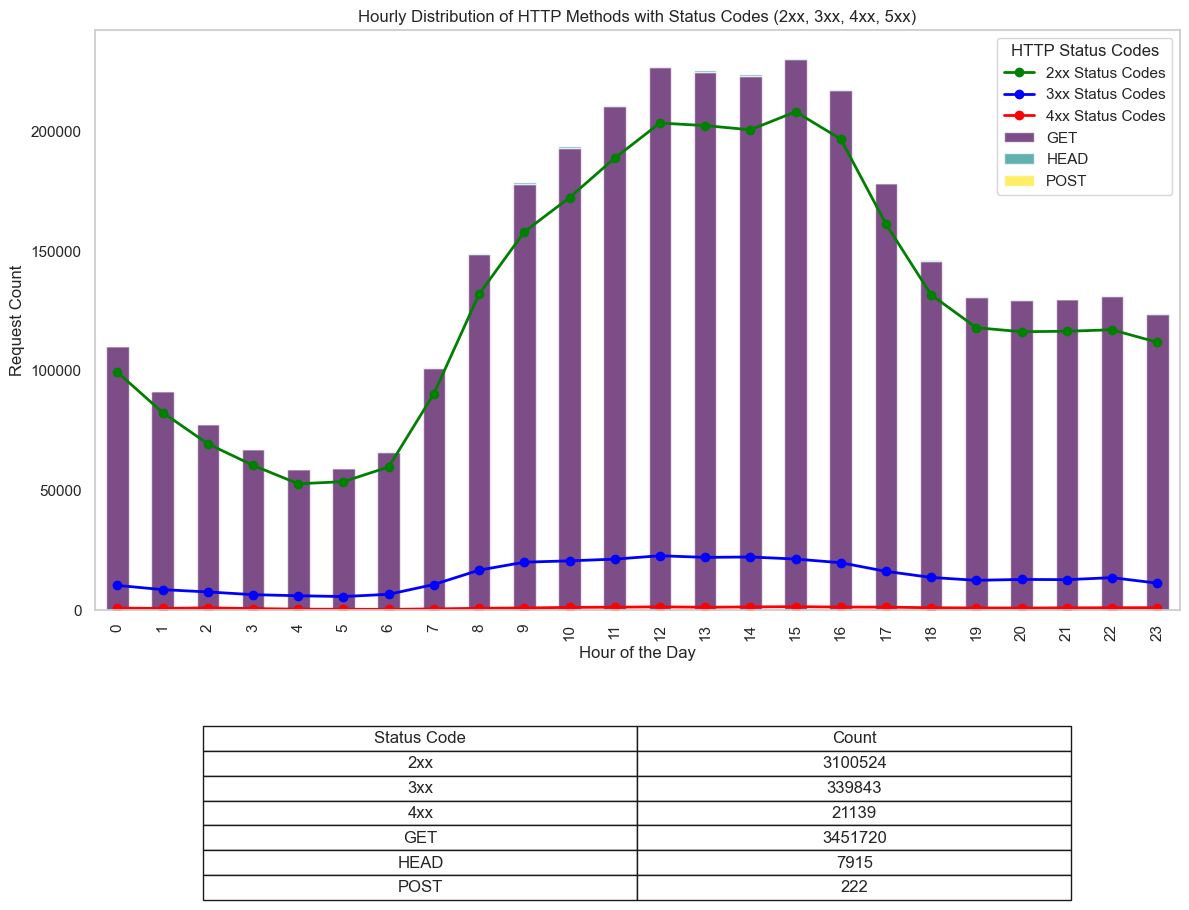

In [28]:
# Count the number of each status code category
status_counts = {
    '2xx': logs_df.filter((F.col('status') >= 200) & (F.col('status') < 300)).count(),
    '3xx': logs_df.filter((F.col('status') >= 300) & (F.col('status') < 400)).count(),
    '4xx': logs_df.filter((F.col('status') >= 400) & (F.col('status') < 500)).count(),
}

# Count the number of each HTTP method
method_counts = {
    'GET': logs_df.filter(F.col('method') == 'GET').count(),
    'HEAD': logs_df.filter(F.col('method') == 'HEAD').count(),
    'POST': logs_df.filter(F.col('method') == 'POST').count(),
}

# Combine counts into a single dictionary for the table
summary_counts = {**status_counts, **method_counts}
# Create the figure and axis
fig, ax = plt.subplots(figsize=(14, 10))

# Plot the hourly distribution of HTTP methods
stacked_data.plot(kind='bar', stacked=True, colormap="viridis", ax=ax, alpha=0.7)

# Overlay the status lines

ax.plot(twoxx_hourly_counts_pd['hour'], twoxx_hourly_counts_pd['count'], 
        color='green', label='2xx Status Codes', linewidth=2, marker='o')
ax.plot(threexx_hourly_counts_pd['hour'], threexx_hourly_counts_pd['count'], 
        color='blue', label='3xx Status Codes', linewidth=2, marker='o')

ax.plot(fourxx_hourly_counts_pd['hour'], fourxx_hourly_counts_pd['count'],
        color='red', label='4xx Status Codes', linewidth=2, marker='o')


# Add titles and labels
ax.set_title("Hourly Distribution of HTTP Methods with Status Codes (2xx, 3xx, 4xx, 5xx)")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Request Count")
ax.legend(title="HTTP Status Codes")
ax.grid()

# Create a table below the plot
table_data = [
    ['Status Code', 'Count'],
    ['2xx', status_counts['2xx']],
    ['3xx', status_counts['3xx']],
    ['4xx', status_counts['4xx']],
  
    ['GET', method_counts['GET']],
    ['HEAD', method_counts['HEAD']],
    ['POST', method_counts['POST']],
]

# Create a table
table = ax.table(cellText=table_data, colLabels=None, cellLoc='center', loc='bottom', bbox=[0.1, -0.5, 0.8, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Adjust layout to make room for the table
plt.subplots_adjust(bottom=0.3)

# Show the plot
plt.show()

D:\Anaconda\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
D:\Anaconda\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


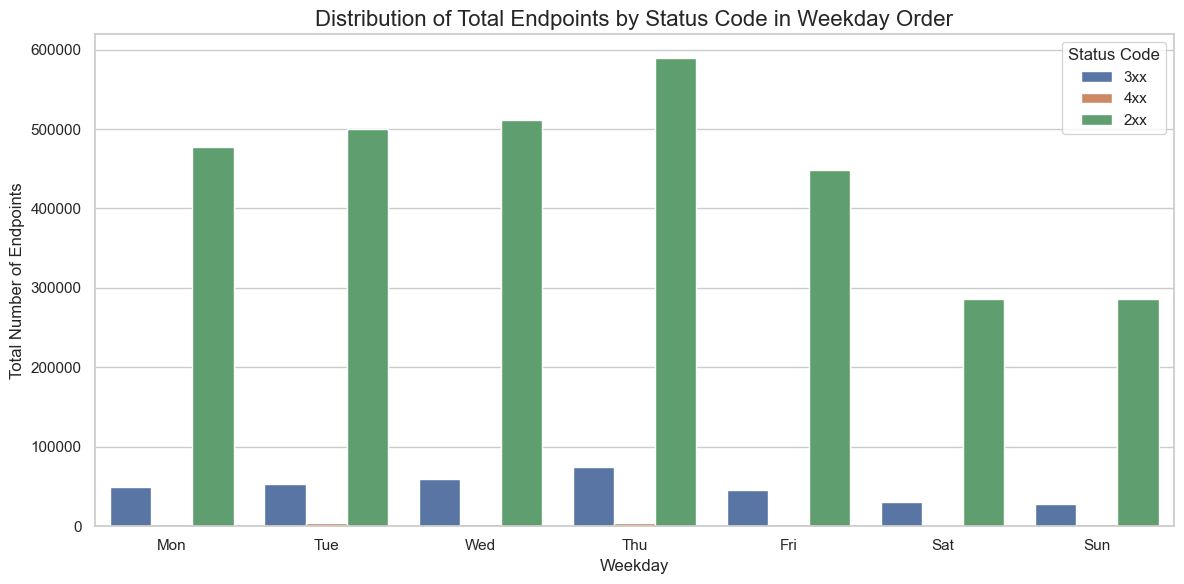


Summary Table of Total Endpoints by Status Code:
  status_code  total_endpoints
0         2xx          3100524
1         3xx           339843
2         4xx            21139


In [30]:
import seaborn as sns
import pandas as pd

# Add a 'weekday' column to the DataFrame
logs_df = logs_df.withColumn('weekday', F.date_format('time', 'E'))  # 'E' gives abbreviated day name

# Create a new column for status categories
logs_df = logs_df.withColumn(
    'status_code',
    F.when((F.col('status') >= 200) & (F.col('status') < 300), '2xx')
    .when((F.col('status') >= 300) & (F.col('status') < 400), '3xx')
    .when((F.col('status') >= 400) & (F.col('status') < 500), '4xx')  
    .otherwise('Other')
)

# Group by 'weekday' and 'status_code' to count total endpoints
endpoint_counts = logs_df.groupBy(['weekday', 'status_code']) \
    .agg(F.count('endpoint').alias('total_endpoints'))

# Convert the aggregated DataFrame to Pandas
endpoint_counts_pd = endpoint_counts.toPandas()

# Define the order for weekdays
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Convert 'weekday' to a categorical type with the defined order
endpoint_counts_pd['weekday'] = pd.Categorical(endpoint_counts_pd['weekday'], categories=weekday_order, ordered=True)

# Sort the data by weekday
endpoint_counts_pd = endpoint_counts_pd.sort_values('weekday')

# Filter to keep only 4xx and other relevant status codes
endpoint_counts_pd = endpoint_counts_pd[endpoint_counts_pd['status_code'].isin(['2xx', '3xx', '4xx'])]

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a bar plot for total endpoints by weekday and status code
plt.figure(figsize=(12, 6))
sns.barplot(data=endpoint_counts_pd, x='weekday', y='total_endpoints', hue='status_code', errorbar=None)

# Add titles and labels
plt.title("Distribution of Total Endpoints by Status Code in Weekday Order", fontsize=16)
plt.xlabel("Weekday", fontsize=12)
plt.ylabel("Total Number of Endpoints", fontsize=12)
plt.legend(title='Status Code')

# Show the plot
plt.tight_layout()
plt.show()

# Generate a summary table for total endpoints by status code
summary_table = endpoint_counts_pd.groupby('status_code')['total_endpoints'].sum().reset_index()

# Display the summary table
print("\nSummary Table of Total Endpoints by Status Code:")
print(summary_table)

### Part 3

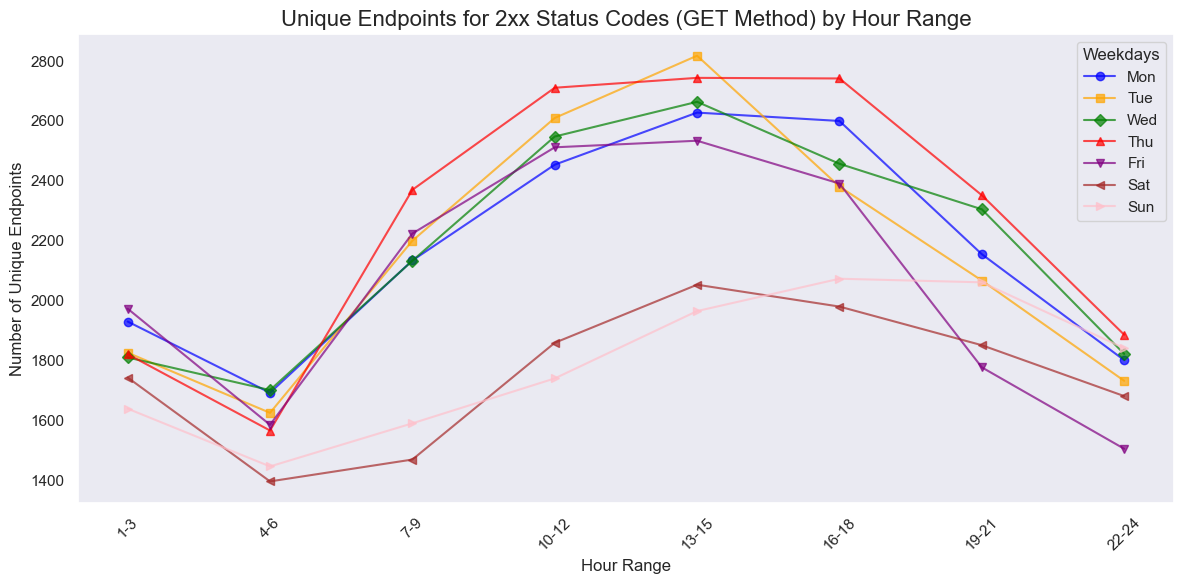

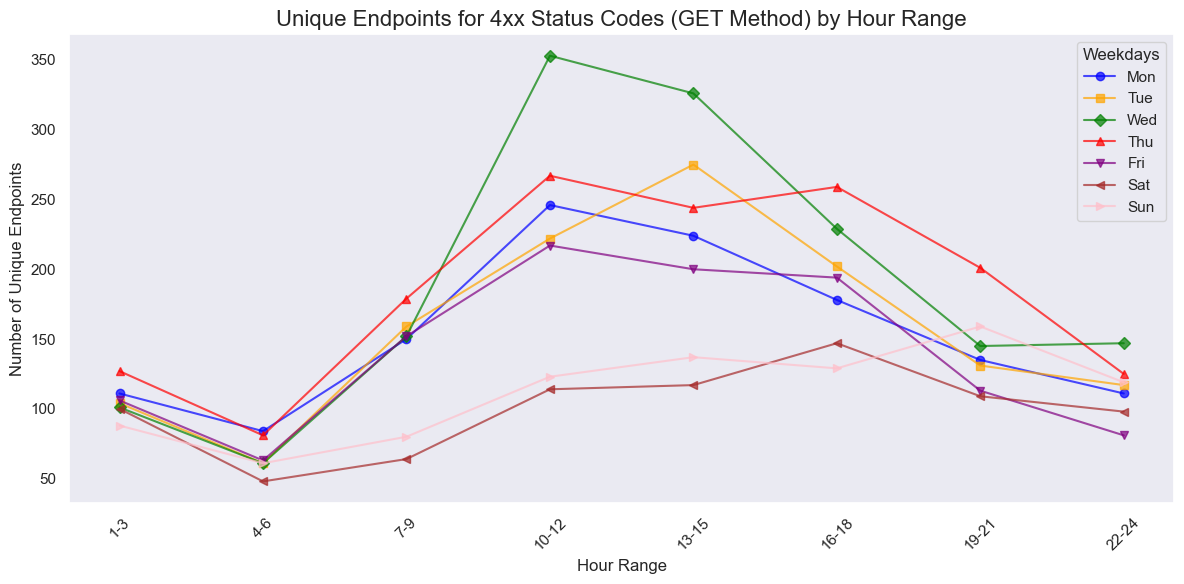

In [75]:
# Function to process and plot data for a given status code range
def plot_unique_endpoints_by_status(logs_df, status_code_range, title):
    # Step 1: Filter for the specified status codes and the GET method
    filtered_df = logs_df.filter(
        (F.col('status') >= status_code_range[0]) & (F.col('status') < status_code_range[1]) & (F.col('method') == 'GET')
    )

    # Step 2: Add 'hour' and 'weekday' columns to the DataFrame
    filtered_df = filtered_df.withColumn('hour', F.hour('time'))  # Extract hour from the timestamp
    filtered_df = filtered_df.withColumn('weekday', F.date_format('time', 'E'))  # Get abbreviated day name

    # Step 3: Create a new column for hour ranges
    filtered_df = filtered_df.withColumn(
        'hour_range',
        F.when((F.col('hour') >= 1) & (F.col('hour') <= 3), '1-3')
        .when((F.col('hour') >= 4) & (F.col('hour') <= 6), '4-6')
        .when((F.col('hour') >= 7) & (F.col('hour') <= 9), '7-9')
        .when((F.col('hour') >= 10) & (F.col('hour') <= 12), '10-12')
        .when((F.col('hour') >= 13) & (F.col('hour') <= 15), '13-15')
        .when((F.col('hour') >= 16) & (F.col('hour') <= 18), '16-18')
        .when((F.col('hour') >= 19) & (F.col('hour') <= 21), '19-21')
        .when((F.col('hour') >= 22) & (F.col('hour') <= 24), '22-24')
    )

    # Step 4: Group by 'weekday' and 'hour_range' to count unique endpoints
    hourly_endpoint_counts = filtered_df.groupBy('weekday', 'hour_range').agg(F.countDistinct('endpoint').alias('unique_endpoints'))

    # Step 5: Convert to Pandas DataFrame for plotting
    hourly_endpoint_counts_pd = hourly_endpoint_counts.toPandas()

    # Step 6: Drop rows with NaN values
    hourly_endpoint_counts_pd.dropna(inplace=True)

    # Step 7: Define the order for weekdays
    weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    hourly_endpoint_counts_pd['weekday'] = pd.Categorical(hourly_endpoint_counts_pd['weekday'], categories=weekday_order, ordered=True)

    # Step 8: Define the order for hour ranges
    hour_range_order = ['1-3', '4-6', '7-9', '10-12', '13-15', '16-18', '19-21', '22-24']
    hourly_endpoint_counts_pd['hour_range'] = pd.Categorical(hourly_endpoint_counts_pd['hour_range'], categories=hour_range_order, ordered=True)

    # Step 9: Sort the data by weekday and hour_range
    hourly_endpoint_counts_pd = hourly_endpoint_counts_pd.sort_values(['hour_range', 'weekday'])

    # Step 10: Create a line plot for each weekday
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

    # Define colors and markers for each weekday
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
    markers = ['o', 's', 'D', '^', 'v', '<', '>']

    # Plot each weekday
    for i, weekday in enumerate(weekday_order):
        weekday_data = hourly_endpoint_counts_pd[hourly_endpoint_counts_pd['weekday'] == weekday]
        
        # Plot the line for the current weekday
        plt.plot(weekday_data['hour_range'].astype(str), weekday_data['unique_endpoints'], 
                 color=colors[i], marker=markers[i], label=weekday, alpha=0.7)

    # Add titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel("Hour Range", fontsize=12)
    plt.ylabel("Number of Unique Endpoints", fontsize=12)
    plt.xticks(rotation=45 )  # Rotate x-axis labels for better readability
    plt.grid()
    plt.legend(title='Weekdays')
    plt.tight_layout()
    plt.show()

# Plot for 2xx status codes
plot_unique_endpoints_by_status(logs_df, (200, 300), "Unique Endpoints for 2xx Status Codes (GET Method) by Hour Range")

# Plot for 4xx status codes
plot_unique_endpoints_by_status(logs_df, (400, 600), "Unique Endpoints for 4xx Status Codes (GET Method) by Hour Range")

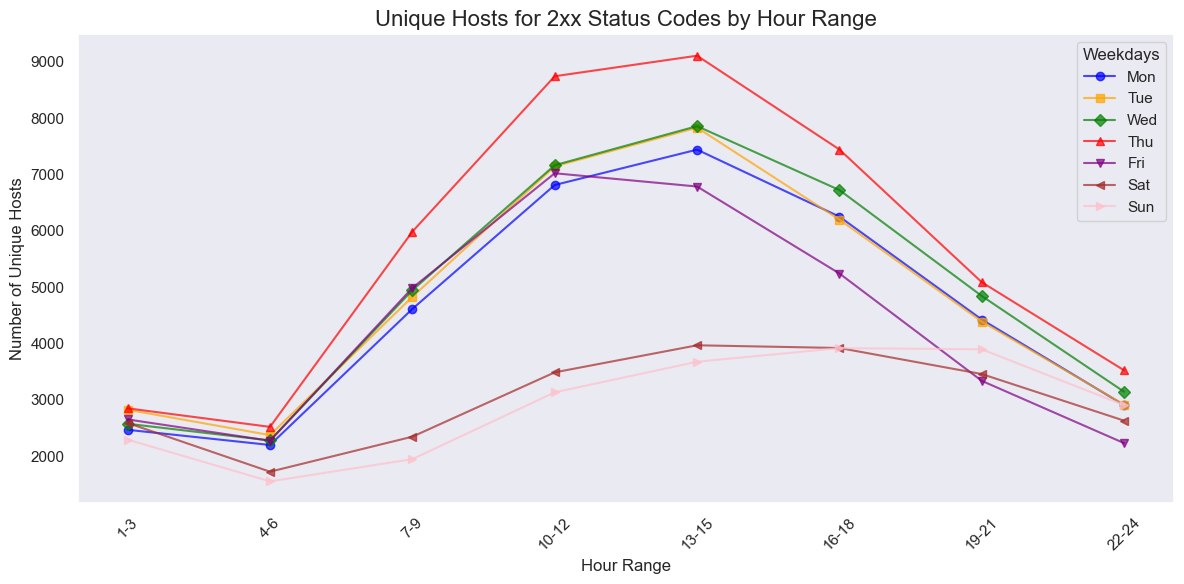

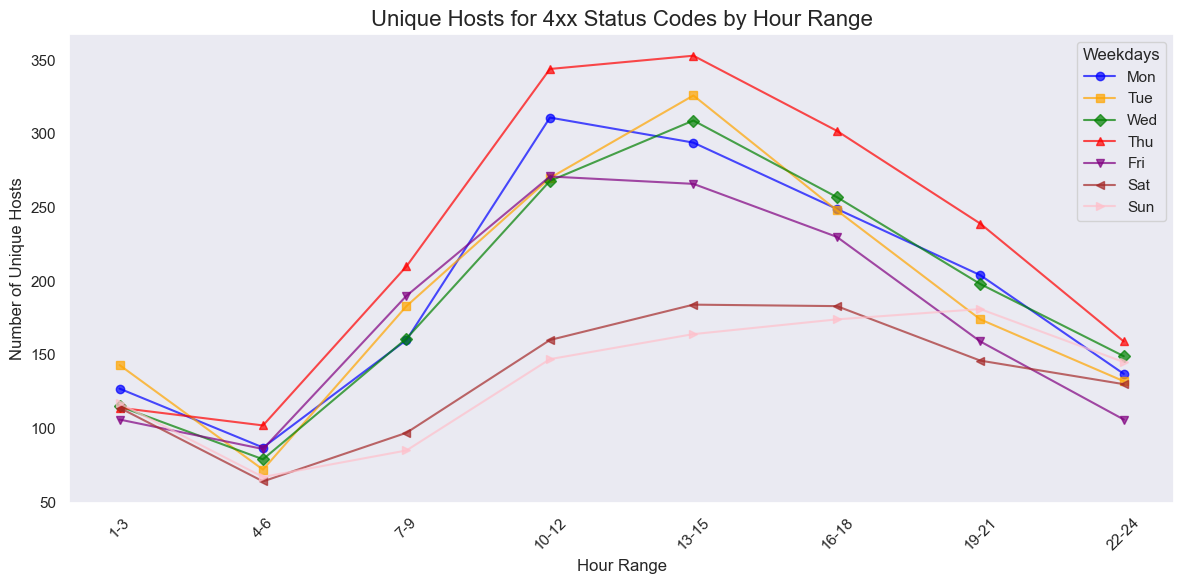

In [76]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd

# Function to process and plot data for a given status code range
def plot_unique_hosts_by_status(logs_df, status_code_range, title):
    # Step 1: Filter for the specified status codes
    filtered_df = logs_df.filter((F.col('status') >= status_code_range[0]) & (F.col('status') < status_code_range[1]))

    # Step 2: Add 'hour' and 'weekday' columns to the DataFrame
    filtered_df = filtered_df.withColumn('hour', F.hour('time'))  # Extract hour from the timestamp
    filtered_df = filtered_df.withColumn('weekday', F.date_format('time', 'E'))  # Get abbreviated day name

    # Step 3: Create a new column for hour ranges
    filtered_df = filtered_df.withColumn(
        'hour_range',
        F.when((F.col('hour') >= 1) & (F.col('hour') <= 3), '1-3')
        .when((F.col('hour') >= 4) & (F.col('hour') <= 6), '4-6')
        .when((F.col('hour') >= 7) & (F.col('hour') <= 9), '7-9')
        .when((F.col('hour') >= 10) & (F.col('hour') <= 12), '10-12')
        .when((F.col('hour') >= 13) & (F.col('hour') <= 15), '13-15')
        .when((F.col('hour') >= 16) & (F.col('hour') <= 18), '16-18')
        .when((F.col('hour') >= 19) & (F.col('hour') <= 21), '19-21')
        .when((F.col('hour') >= 22) & (F.col('hour') <= 24), '22-24')
    )

    # Step 4: Group by 'weekday' and 'hour_range' to count unique hosts
    hourly_host_counts = filtered_df.groupBy('weekday', 'hour_range').agg(F.countDistinct('host').alias('unique_hosts'))

    # Step 5: Convert to Pandas DataFrame for plotting
    hourly_host_counts_pd = hourly_host_counts.toPandas()

    # Step 6: Drop rows with NaN values
    hourly_host_counts_pd.dropna(inplace=True)

    # Step 7: Define the order for weekdays
    weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    hourly_host_counts_pd['weekday'] = pd.Categorical(hourly_host_counts_pd['weekday'], categories=weekday_order, ordered=True)

    # Step 8: Define the order for hour ranges
    hour_range_order = ['1-3', '4-6', '7-9', '10-12', '13-15', '16-18', '19-21', '22-24']
    hourly_host_counts_pd['hour_range'] = pd.Categorical(hourly_host_counts_pd['hour_range'], categories=hour_range_order, ordered=True)

    # Step 9: Sort the data by weekday and hour_range
    hourly_host_counts_pd = hourly_host_counts_pd.sort_values(['hour_range', 'weekday'])

    # Step 10: Create a line plot for each weekday
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

    # Define colors and markers for each weekday
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
    markers = ['o', 's', 'D', '^', 'v', '<', '>']

    # Plot each weekday
    for i, weekday in enumerate(weekday_order):
        weekday_data = hourly_host_counts_pd[hourly_host_counts_pd['weekday'] == weekday]
        
        # Plot the line for the current weekday
        plt.plot(weekday_data['hour_range'].astype(str), weekday_data['unique_hosts'], 
                 color=colors[i], marker=markers[i], label=weekday, alpha=0.7)

    # Add titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel("Hour Range", fontsize=12)
    plt.ylabel("Number of Unique Hosts", fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid()
    plt.legend(title='Weekdays')
    plt.tight_layout()
    plt.show()

# Plot for 2xx status codes
plot_unique_hosts_by_status(logs_df, (200, 300), "Unique Hosts for 2xx Status Codes by Hour Range")

# Plot for 4xx status codes
plot_unique_hosts_by_status(logs_df, (400, 600), "Unique Hosts for 4xx Status Codes by Hour Range")